In [1]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [5]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [2]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [3]:
def bonos_dbAlgebra(n,cn):

    niu_data = pd.DataFrame()

    bonos = "SELECT TOP ("+ str(n) +") Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, NemotecnicoBono AS Nemotecnico, RiesgoInt FROM (SELECT * FROM (SELECT Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, Nemotecnico AS NemotecnicoBono FROM [dbAlgebra].[dbo].[TdNemoRF]) AS bono JOIN (SELECT * FROM [dbPortFolio].[dbo].[TdPlanvitalCartera]) AS planvital ON bono.FechaEmision > '20190101' AND bono.NemotecnicoBono = planvital.Nemotecnico) AS A JOIN (SELECT DISTINCT Nemotecnico, RiesgoLVA AS RiesgoInt FROM [dbAlgebra].[dbo].[TdRiesgoLva]) AS B ON A.NemotecnicoBono = B.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)

    moneda = []
    base1 = []
    base2 = []
    tabla = []
    fechaemi = []
    nemotecnico = []
    riesgo = []
    for i in range(np.size(bonos, 0)):

        if bonos["Nemotecnico"][i] in nemotecnico: continue

        if bonos["RiesgoInt"][i] in riesgo : continue

        moneda.append(bonos["Moneda"][i])
        base1.append(bonos["Base1"][i])
        base2.append(bonos["Base2"][i])
        tabla.append(bonos["TablaDesarrollo"][i])
        fechaemi.append(bonos["FechaEmision"][i])
        nemotecnico.append(bonos["Nemotecnico"][i])
        riesgo.append(bonos["RiesgoInt"][i])

    niu_data["Moneda"] = moneda
    niu_data["Base1"] = base1
    niu_data["Base2"] = base2
    niu_data["TablaDesarrollo"] = tabla
    niu_data["FechaEmision"] = fechaemi
    niu_data["Nemotecnico"] = nemotecnico
    niu_data["RiesgoInt"] = riesgo


    return niu_data

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = 'BCINO UF 200709_A'
    return derivado

In [4]:
def conversionSYP(riesgo):
    return {-1: "AAA", 1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
bonos = ajustes(bonos_dbAlgebra(500,cn))
bonos

,Moneda,Base1,Base2,TablaDesarrollo,FechaEmision,Nemotecnico,RiesgoInt,Convencion,Riesgo
0,UF,ACT,365,"1#01-10-2019#0,35#0#100#0,35|2#01-04-2020#0,35...",2019-04-01,BSECB90419,3,ACT/365,AA
1,UF,ACT,365,"1#30-04-2019#0,48208#8,1616#91,8384#8,64368|2#...",2019-01-31,BSXXI-A,1,ACT/365,AAA
2,UF,ACT,365,"1#30-10-2019#1,094#0#100#1,094|2#30-04-2020#1,...",2019-04-30,BVIAS-A,4,ACT/365,AA
3,UF,ACT,365,"1#01-03-2020#0,3245#0#100#0,3245|2#01-09-2020#...",2019-09-01,BCSSA-C,2,ACT/365,AA
4,UF,ACT,365,"1#01-12-2019#0,8464#0#100#0,8464|2#01-06-2020#...",2019-06-01,BCMPC-O,-1,ACT/365,AAA
5,UF,ACT,365,"1#15-10-2019#1,7841#0#100#1,7841|2#15-04-2020#...",2019-04-15,BLATM-E,8,ACT/365,BBB


In [7]:
bonos["Riesgo"].values

array(['AA', 'AAA', 'AA', 'AA', 'AAA', 'BBB'], dtype=object)

In [8]:
derivados = derivados_dBDerivados(2, cn)
derivados["Derivado"][0].genera_flujos()
derivados["Derivado"][0].valoriza_flujos()
derivados["Derivado"][0].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1368,-1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,4.331011e+07,4.293818e+07,CLP,CLP
1,1368,-1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.549401e+07,3.494116e+07,CLP,CLP
2,1368,-1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,4.784481e+07,4.665317e+07,CLP,CLP
3,1368,-1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.042244e+09,4.875468e+09,CLP,CLP
4,1368,1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,3.652233e+07,3.620869e+07,CLP,CLP
5,1368,1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.692515e+07,3.635001e+07,CLP,CLP
6,1368,1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,3.632093e+07,3.541630e+07,CLP,CLP
7,1368,1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.036925e+09,4.870324e+09,CLP,CLP


In [9]:
arreglo_acciones = ["AESGENER", "AGUAS-A", "ANDINA-A", "ANDINA-B", "DE000DWS2D90", "ANTARCHILE"]
arreglo_fondos = ["A", "A", "A", "A", "A", "A"]


acciones = historico(arreglo_acciones, arreglo_fondos, 60)
acciones


,Moneda,Nombre,Nemotecnico,Inversion,Historico
0,CLP,AESGENER,AESGENER,1.743959e+09,"[[0, 0.0025957870479299534, -0.007433469137058..."
1,CLP,AGUAS-A,AGUAS-A,1.566402e+07,"[[0, 0.003305297208302039, 0.03566773260328181..."
2,CLP,ANDINA-A,ANDINA-A,1.492768e+08,"[[0, 0.00034804011961498776, 0.018505998119275..."
3,CLP,ANDINA-B,ANDINA-B,1.098975e+09,"[[0, 0.005746838657845234, 0.0175731917247771,..."
4,CLP,DE000DWS2D90,DE000DWS2D90,1.258575e+10,"[[0, -0.011984448831005957, -0.025391621016988..."
5,CLP,ANTARCHILE,ANTARCHILE,1.567905e+08,"[[0, 0.009876696995043567, 0.00310408270978682..."


      0.749154      0.822707   

              CLP#1623#AAA  CLP#1804#AAA  CLP#1998#AAA  CLP#2178#AAA  \
CLP#16#AAA        0.671805      0.607268      0.558310      0.510229   
CLP#191#AAA       0.689507      0.620413      0.567537      0.515894   
CLP#349#AAA       0.666516      0.596203      0.541885      0.489182   
CLP#384#AAA       0.668155      0.597947      0.543717      0.491080   
CLP#528#AAA       0.689820      0.620942      0.568026      0.516367   
CLP#563#AAA       0.695084      0.626585      0.574036      0.522656   
CLP#709#AAA       0.717398      0.650810      0.600064      0.550087   
CLP#744#AAA       0.733638      0.668443      0.618714      0.569553   
CLP#902#AAA       0.832850      0.778025      0.735647      0.692557   
CLP#1083#AAA      0.933893      0.896501      0.866648      0.834295   
CLP#1248#AAA      0.969515      0.940665      0.916960      0.889966   
CLP#1277#AAA      0.974588      0.947393      0.924887      0.898947   
CLP#1443#AAA      0.994642     

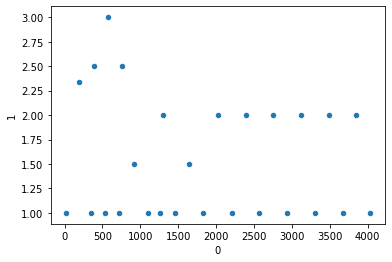

In [20]:
cartera = Cartera(acciones, bonos.head(3), derivados, "CLP", datetime.date(2019, 10, 14), cn)

In [11]:
cartera.get_diccionario_niveles()

{1: {('Renta Variable Nacional Acciones',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.56790546e+08]),
  ('Renta Variable Extranjera',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.25857487e+10, 0.00000000e+00]),
  ('Renta Fija Nacional',
   'Bono',
   'AA'): array([0.00000000e+00, 9.50658652e-03, 2.35642215e-01, 1.73726750e-02,
         2.33797613e-01, 1.07118800e-02, 1.36305126e-02, 7.38935635e-02,
         1.83978196e-02, 7.87359261e-05, 3.74814475e-03, 2.86966270e-03,
         4.92164506e-05, 2.04353495e-03, 5.97029946e-03, 1.04498792e-01,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
  ('Renta Fija Nacional ',
   'Bono',
   'AAA'): array([0.        , 8.44540711, 1.16358247, 0.        , 0.        ,
         0.6

In [24]:
print(cartera.get_bonos()[0].get_historicos())

0.999548   0.992114   0.979814   0.977290   0.968922   0.966900   
13  0.999548   0.992268   0.980520   0.978099   0.969953   0.967978   
14  0.999559   0.994087   0.988013   0.986504   0.979605   0.977759   
15  0.999549   0.992407   0.981149   0.978826   0.970941   0.969029   
16  0.999559   0.994090   0.988026   0.986520   0.979637   0.977796   
17  0.999549   0.992360   0.980938   0.978590   0.970693   0.968784   
18  0.999549   0.992384   0.981044   0.978704   0.970775   0.968853   
19  0.999549   0.992420   0.981206   0.978900   0.971115   0.969233   
20  0.999549   0.992432   0.981260   0.978954   0.971117   0.969217   
21  0.999549   0.992432   0.981261   0.978964   0.971202   0.969325   
22  0.999549   0.992436   0.981276   0.978973   0.971143   0.969245   
23  0.999551   0.992708   0.982475   0.980365   0.973113   0.971359   
24  0.999552   0.992990   0.983682   0.981749   0.974928   0.973273   
25  0.999558   0.993987   0.987644   0.986047   0.978651   0.976651   
26  0.9995

In [22]:
print(cartera.get_retornos_totales())

 3.916884e-04  5.762630e-04   
40 -3.653563e-05 -0.000039 -0.000011 -9.976846e-06 -5.026320e-05   
41  1.108323e-05 -0.000028  0.000323  3.771569e-04  3.490244e-04   
42 -8.365831e-05 -0.000073  0.000184  2.156998e-04  3.160671e-05   
43  8.272423e-04  0.000702 -0.000239 -3.615547e-04 -1.759318e-04   
44  6.607216e-04  0.000598  0.000067 -9.628019e-06 -1.367243e-06   
45 -8.728163e-05 -0.000104 -0.000011 -4.956933e-07 -4.784219e-05   
46  2.092865e-04  0.000249  0.000159  1.500175e-04  1.084536e-04   
47 -1.133561e-05 -0.000022 -0.000328 -3.869976e-04 -5.658130e-04   
48 -8.833766e-07  0.000041  0.000134  1.524995e-04  1.937270e-04   
49  5.283568e-04  0.000441  0.000182  1.363908e-04  1.042196e-04   
50 -2.106493e-03 -0.001933 -0.000810 -6.909905e-04 -9.985829e-04   
51 -4.842493e-04 -0.000590 -0.001429 -1.602515e-03 -2.160473e-03   
52  3.357371e-04  0.000354  0.000109  6.974400e-05  5.967246e-06   
53  9.837930e-05  0.000082 -0.000243 -3.167876e-04 -5.639859e-04   
54 -8.646061e-06 

In [14]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

0.003976729481302065


In [15]:
cartera.get_covarianza()

,CLP#16#AA,CLP#168#AA,CLP#203#AA,CLP#349#AA,CLP#384#AA,CLP#551#AA,CLP#709#AA,CLP#744#AA,CLP#902#AA,CLP#1083#AA,CLP#1248#AA,CLP#1277#AA,CLP#1443#AA,CLP#1623#AA,CLP#1804#AA,CLP#1998#AA,CLP#2178#AA,CLP#2358#AA,CLP#2538#AA,CLP#2718#AA,CLP#2898#AA,CLP#3079#AA,CLP#3259#AA,CLP#3439#AA,CLP#3619#AA,CLP#3799#AA,CLP#3979#AA,CLP#16#AAA,CLP#168#AAA,CLP#203#AAA,CLP#349#AAA,CLP#384#AAA,CLP#551#AAA,CLP#709#AAA,CLP#744#AAA,CLP#902#AAA,CLP#1083#AAA,CLP#1248#AAA,CLP#1277#AAA,CLP#1443#AAA,CLP#1623#AAA,CLP#1804#AAA,CLP#1998#AAA,CLP#2178#AAA,CLP#2358#AAA,CLP#2538#AAA,CLP#2718#AAA,CLP#2898#AAA,CLP#3079#AAA,CLP#3259#AAA,CLP#3439#AAA,CLP#3619#AAA,CLP#3799#AAA,CLP#3979#AAA,CLP#16,CLP#168,CLP#203,CLP#349,CLP#384,CLP#551,CLP#709,CLP#744,CLP#902,CLP#1083,CLP#1248,CLP#1277,CLP#1443,CLP#1623,CLP#1804,CLP#1998,CLP#2178,CLP#2358,CLP#2538,CLP#2718,CLP#2898,CLP#3079,CLP#3259,CLP#3439,CLP#3619,CLP#3799,CLP#3979,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#16#AA,1.610693e-07,0.000002,0.000002,0.000004,0.000005,0.000007,0.000008,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,1.934965e-07,0.000002,0.000002,0.000004,0.000005,0.000007,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,-6.089885e-10,3.467197e-09,8.984566e-09,1.525940e-09,4.327593e-09,-3.138880e-10,6.580755e-10,1.317727e-09,6.222756e-09,1.184181e-08,1.298573e-08,1.295760e-08,1.279654e-08,1.801639e-08,2.325824e-08,1.454980e-08,4.684294e-09,-2.136616e-10,-3.567650e-09,-1.601597e-08,-2.957688e-08,-3.930242e-08,-4.837089e-08,-2.420463e-08,7.720306e-09,6.808551e-09,-2.344233e-09,7.290707e-07,-0.000001,4.294431e-07,5.568430e-07,-6.977933e-07,-9.601533e-07
CLP#168#AA,1.665458e-06,0.000020,0.000025,0.000050,0.000056,0.000079,0.000100,0.000102,0.000107,0.000104,0.000105,0.000105,0.000102,0.000103,0.000100,0.000100,0.000098,0.000097,0.000096,0.000096,0.000094,0.000094,0.000092,0.000092,0.000090,0.000089,0.000088,2.035539e-06,0.000022,0.000027,0.000050,0.000055,0.000079,0.000101,0.000104,0.000108,0.000106,0.000107,0.000107,0.000104,0.000104,0.000102,0.000102,0.000100,0.000099,0.000098,0.000097,0.000096,0.000096,0.000095,0.000094,0.000093,0.000092,0.000090,-5.786595e-08,-1.052829e-07,-5.065736e-08,-1.749779e-07,-1.388982e-07,2.435510e-08,3.787598e-09,5.241104e-09,5.609715e-08,1.143563e-07,1.495033e-07,1.537856e-07,1.782981e-07,2.530155e-07,3.251679e-07,1.582177e-07,-3.002328e-08,-1.613610e-07,-2.755634e-07,-3.941186e-07,-5.147668e-07,-7.443859e-07,-9.923786e-07,-7.699448e-07,-4.398596e-07,-4.876838e-07,-6.316317e-07,8.649144e-06,-0.000013,1.474845e-05,1.175956e-05,-7.649430e-06,-9.351678e-06
CLP#203#AA,2.066813e-06,0.000025,0.000031,0.000063,0.000071,0.000099,0.000124,0.000127,0.000132,0.000128,0.000130,0.000130,0.000126,0.000126,0.000122,0.000121,0.000118,0.000118,0.000116,0.000115,0.000113,0.000112,0.000110,0.000109,0.000107,0.000105,0.000103,2.526793e-06,0.000028,0.000034,0.000063,0.000069,0.000098,0.000125,0.000129,0.000134,0.000130,0.000132,0.000132,0.000128,0.000128,0.000124,0.000123,0.000121,0.000120,0.000118,0.000117,0.000115,0.000114,0.000112,0.000111,0.000109,0.000108,0.000106,-7.450802e-08,-1.386045e-07,-6.901523e-08,-2.189245e-07,-1.727485e-07,3.394994e-08,5.317419e-09,7.183230e-09,7.317226e-08,1.487673e-07,1.902870e-07,1.950365e-07,2.222229e-07,3.177537e-07,4.100671e-07,1.982341e-07,-4.059059e-08,-2.082969e-07,-3.546510e-07,-5.021724e-07,-6.518243e-07,-9.529508e-07,-1.279627e-06,-1.005784e-06,-5.945856e-07,-6.557175e-07,-8.373147e-07,1.043775e-05,-0.000017,1.885173e-05,1.498390e-05,-9.332440e-06,-1.182359e-05
CLP#349#AA,4.086564e-06,0.000050,0.000063,0.000134,0.000150,0.000205,0.000248,0.000254,0.000259,0.000245,0.000246,0.000245,0.000234,0.000231,0.000220,0.000214,0.000204,0.000200,0.000193,0.000188,0.000181,0.000176

In [16]:
cartera.get_correlacion()

,CLP#16#AA,CLP#168#AA,CLP#203#AA,CLP#349#AA,CLP#384#AA,CLP#551#AA,CLP#709#AA,CLP#744#AA,CLP#902#AA,CLP#1083#AA,CLP#1248#AA,CLP#1277#AA,CLP#1443#AA,CLP#1623#AA,CLP#1804#AA,CLP#1998#AA,CLP#2178#AA,CLP#2358#AA,CLP#2538#AA,CLP#2718#AA,CLP#2898#AA,CLP#3079#AA,CLP#3259#AA,CLP#3439#AA,CLP#3619#AA,CLP#3799#AA,CLP#3979#AA,CLP#16#AAA,CLP#168#AAA,CLP#203#AAA,CLP#349#AAA,CLP#384#AAA,CLP#551#AAA,CLP#709#AAA,CLP#744#AAA,CLP#902#AAA,CLP#1083#AAA,CLP#1248#AAA,CLP#1277#AAA,CLP#1443#AAA,CLP#1623#AAA,CLP#1804#AAA,CLP#1998#AAA,CLP#2178#AAA,CLP#2358#AAA,CLP#2538#AAA,CLP#2718#AAA,CLP#2898#AAA,CLP#3079#AAA,CLP#3259#AAA,CLP#3439#AAA,CLP#3619#AAA,CLP#3799#AAA,CLP#3979#AAA,CLP#16,CLP#168,CLP#203,CLP#349,CLP#384,CLP#551,CLP#709,CLP#744,CLP#902,CLP#1083,CLP#1248,CLP#1277,CLP#1443,CLP#1623,CLP#1804,CLP#1998,CLP#2178,CLP#2358,CLP#2538,CLP#2718,CLP#2898,CLP#3079,CLP#3259,CLP#3439,CLP#3619,CLP#3799,CLP#3979,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#16#AA,1.000000,0.933584,0.925776,0.878413,0.879448,0.915393,0.931717,0.931462,0.914939,0.845345,0.796520,0.786005,0.712483,0.658162,0.594000,0.545058,0.497006,0.461731,0.425648,0.398070,0.370579,0.348846,0.327464,0.310063,0.292861,0.278636,0.264586,0.994639,0.940955,0.938522,0.929230,0.929143,0.932994,0.933536,0.932754,0.913064,0.840841,0.791657,0.781104,0.707586,0.653438,0.589741,0.541553,0.494278,0.459568,0.424081,0.397002,0.370003,0.348655,0.327647,0.310530,0.293609,0.279626,0.265816,-0.012686,0.012783,0.030916,0.003899,0.011233,-0.001069,0.001721,0.003257,0.012268,0.018847,0.017759,0.017293,0.014964,0.018821,0.021850,0.012089,0.003484,-0.000148,-0.002301,-0.009762,-0.017022,-0.021820,-0.025830,-0.012352,0.003747,0.003161,-0.001044,0.135085,-0.286130,0.052346,0.066684,-0.218528,-0.194206
CLP#168#AA,0.933584,1.000000,0.999263,0.977296,0.978120,0.996498,0.988346,0.984865,0.957829,0.870659,0.816814,0.805303,0.725289,0.664252,0.592978,0.537865,0.484364,0.446375,0.407630,0.377833,0.348180,0.324730,0.301635,0.282426,0.263440,0.247522,0.231900,0.944722,0.991484,0.992663,0.995480,0.995409,0.992290,0.984528,0.981904,0.952122,0.863527,0.809232,0.797665,0.717568,0.656770,0.586070,0.531796,0.479177,0.441808,0.403708,0.374459,0.345340,0.322318,0.299634,0.280752,0.262092,0.246456,0.231114,-0.108835,-0.035046,-0.015738,-0.040366,-0.032552,0.007489,0.000894,0.001170,0.009985,0.016433,0.018461,0.018531,0.018825,0.023865,0.027581,0.011869,-0.002016,-0.010080,-0.016045,-0.021689,-0.026748,-0.037313,-0.047846,-0.035475,-0.019276,-0.020442,-0.025402,0.144692,-0.302891,0.162314,0.127148,-0.216293,-0.170783
CLP#203#AA,0.925776,0.999263,1.000000,0.984677,0.985353,0.998311,0.983531,0.979179,0.949433,0.858753,0.804219,0.792596,0.712025,0.650358,0.578583,0.522885,0.468987,0.431068,0.392437,0.362735,0.333192,0.309838,0.286831,0.267583,0.248558,0.232530,0.216825,0.937086,0.987252,0.988963,0.994198,0.994022,0.988669,0.978535,0.975392,0.943085,0.851338,0.796364,0.784687,0.704034,0.642621,0.571438,0.516589,0.463585,0.426289,0.388303,0.359149,0.330138,0.307213,0.284617,0.265699,0.247003,0.231260,0.215839,-0.111978,-0.036868,-0.017133,-0.040357,-0.032351,0.008342,0.001003,0.001281,0.010407,0.017082,0.018775,0.018780,0.018748,0.023949,0.027794,0.011883,-0.002178,-0.010397,-0.016501,-0.022083,-0.027065,-0.038169,-0.049299,-0.037030,-0.020821,-0.021963,-0.026907,0.139528,-0.301336,0.165786,0.129458,-0.210859,-0.172540
CLP#349#AA,0.878413,0.977296,0.984677,1.000000,0.999976,0.987775,0.942818,0.934513,0.892607,0.787167,0.730273,0.718320,0.636474,0.572931,0.500079,0.442631,0.387835,0.350915,0.313505,0.284787,0.256295,0.233819,0.211650,0.192577,0.173723,0.157479,0.141683,0.889444,0.949660,0.953703,0.969816,0.969135,0.953479,0.932518,0.926997,0.883342,0.778363,0.721076,0.709073,0.627144,0.563921,0.491727,0.435160,0.381300,0.345005,0.308225,0.280048,0.252072,0.230019,0.208252,0.189520,0.171007,0.155060,0.139564,-0.120877,-0.042794,-0.021328,-0.037646,-0.028835,0.011908,0.001907,0.002283,0.012661,0.020248,0.020162,0.019823,0.018110,0

In [17]:
cartera.get_volatilidad_niveles()

{1: {('Renta Variable Nacional Acciones', 'Accion'): 0.012318889593453,
  ('Renta Variable Extranjera', 'Accion'): 0.00795634184685601,
  ('Renta Fija Nacional', 'Bono', 'AA'): 0.006846474446263272,
  ('Renta Fija Nacional ', 'Bono', 'AAA'): 0.026898769604516714,
  ('Renta Fija Nacional ', 'Bono', 'AA'): 0.007655488394730536,
  ('Derivados', 'Derivado'): 0.00011961375909576183},
 2: {('Acciones Electricas', 'Accion'): 0.013447928815292927,
  ('Acciones Servicios', 'Accion'): 0.00999697675731327,
  ('Acciones Industrial', 'Accion'): 0.02080684545966357,
  ('Equities Europe', 'Accion'): 0.00795634184685601,
  ('Acciones Recursos Naturales', 'Accion'): 0.012318889593453,
  ('Bonos Financieros', 'Bono', 'AA'): 0.008252876203779196,
  ('Bonos Corporativos', 'Bono', 'AAA'): 0.02687471342835081,
  ('Bonos Corporativos', 'Bono', 'AA'): 0.007652960872393314,
  ('Derivados FWD Inversión', 'Derivado'): 0.00011961375909577863}}

In [18]:
cartera.var_i_porcentual_dinero()

ValueError: operands could not be broadcast together with shapes (54,) (27,) (54,) 

In [ ]:
cartera.var_i_porcentual_dinero(cartera.get_monto())